In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'divmax', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

In [4]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


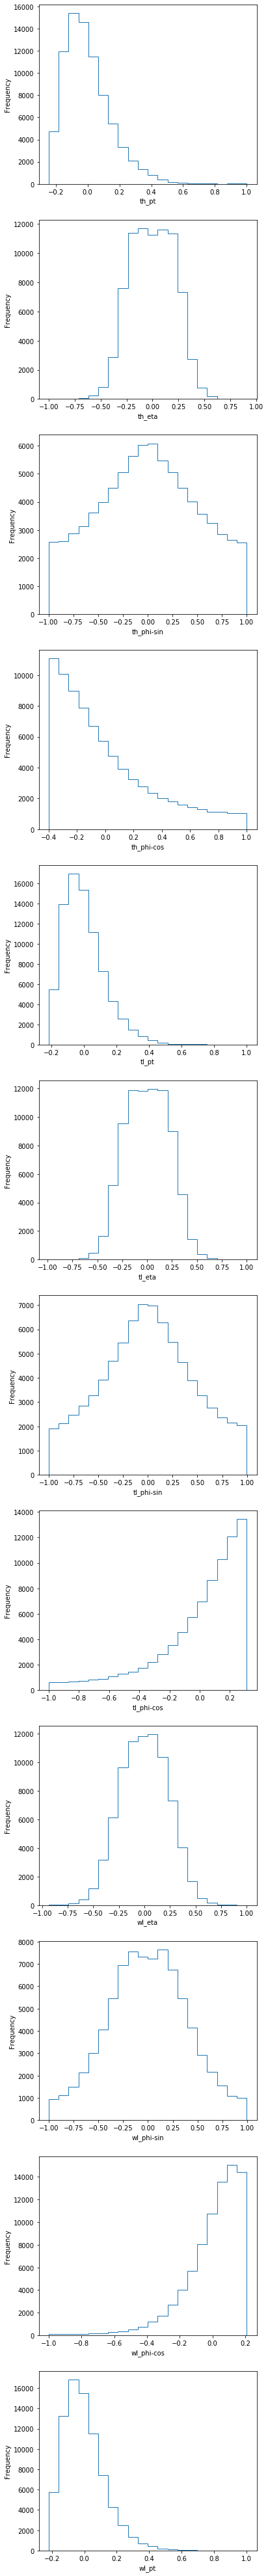

In [7]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

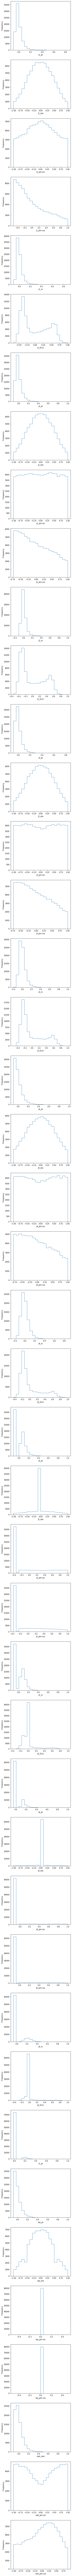

In [9]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [ ]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     X_shape=[len(X_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(Y_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [ ]:
model = build_model()
model.summary()

In [ ]:
# Fit model

Epochs= 2048

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


In [ ]:
history.history.keys()
model.save(model_name)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [ ]:
predictions = model.predict(testX)

In [ ]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*Y_length))
    for i in range(0,Y_length):
        plt.subplot(Y_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(Y_keys[i])
        plt.xlim(0, crop)
        plt.title(Y_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [ ]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

In [ ]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
Y_total, TO_maxmean0 = scale_arrays(Y_keys, maxmean)
out_scaled = invscale_arrays(Y_keys, Y_total, maxmean, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = invscale_arrays(Y_keys, total_predictions, maxmean, TO_maxmean0)[split:,:]


In [ ]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(Y_keys, out_max0, out_mean, Y_total)
# out_scaled = invscale_arrays(Y_keys, testY, maxmean)
# predict_scaled = invscale_arrays(Y_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [ ]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

In [ ]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')